<center><h1 style="line-height:200%;color:#0099cc">
MiniProject2
</h1>

<h4 style="line-height:200%;color:#0099cc">
Importing Libraries and Modules
</h4>

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### The command below turn off warning about chained assignment
pd.options.mode.chained_assignment = None  # default='warn'

<h3 style="line-height:200%;color:#0099cc">
Part 1
</h3>
The next block contains two functions. First one("status(args)") returns a dataframe containg four columns: "salary", "saving_flow"(contribution), "retiremnet_payments" and "balance". It is worth to mention that in "status" function there is no "L_e"(Life expectancy) as it was in the periviuos miniproject.<br>
Second function("NPV_pension(args)") uses the "status(args)" and given parameters to calculate NPV of the pension fund.


In [76]:
def status(age_s, s, a, w, g_p, g_w, r, n, L):
    """
    Set up a dataframe(main_data) containing four columns: salary, saving_flow, retirement_payments, balance
    age_s: The age at which he\she begins working
    s: The percentage of his\her salary that he\she pays to the pension fund
    a: "a" is the percentage of the last yearly salary that is used to calculate the first pension payment
    w: Initial salary
    g_p: Pension payment annual growth rate
    g_w: Salary growth rate
    r: Pension fund annual return rate
    n: The number of years a person has contributed to their pension fund is shown by this parameter
    L: The number of years that pensioner will receive a pension
    """
    main_data = pd.DataFrame()
    
    def salary():
        """
        Adds a column of annual salary to main_data
        """
        data = np.array([w *(1 + g_w/100) ** x for x in range(0,n)] + [0]*L)
        main_data["salary"] = data
        main_data.index = np.array([x for x in range(age_s+1,age_s+n+L+1)])
    
    salary()

    def saving_flow():
        """
        Adds a column of input cashflow(contribution) from the member(form the end of "age_s" to the end of "age_s + n + L") to the main_data
        """
        main_data["saving_flow"] = main_data["salary"] * s/100
    
    saving_flow()

    def retirement_payments():
        """
        Adds an array of retirement payments(form the end of "age_s" to the end of "age_s + n + L") to the main_data
        """
        last_salary = main_data.loc[age_s+n, "salary"]
        first_payment = last_salary * a / 100
        data2 = np.array([0]*n + [first_payment*(1 + g_p/100)**j for j in range(0,L)])
        main_data["retirement_payments"] = data2

    retirement_payments()


    def balance():
        """
        Adds an array of balance status(form the end of "age_s" to the end of "age_s + n + L") to the main_data
        """
        main_data['balance'] = main_data.saving_flow - main_data.retirement_payments
        for index,row in main_data.iterrows():
            if index == age_s+1:
                continue
            main_data.balance.loc[index] = main_data.balance.loc[index] + main_data.balance.loc[index-1] * (1 + r/100)
    
    balance()

    return main_data




def NPV_pension(n):
    """
    Returns NPV of the pension fund base on "n"
    """
    L = 10
    age_s = 20  
    r_d = 14
    temp_dataframe = status(20, 30, 80, 1, 20, 20, 17, n, L)
    temp_balance = temp_dataframe.balance.diff().fillna(temp_dataframe['balance'].loc[age_s+1])  ## difference between each row, index={21,22,...,70}
    temp_balance.index -= age_s  ## change index to {1,2,...,50}
    DCF = temp_balance.divide( (1 + r_d/100) ** temp_balance.index) ### dicounted blance each year 
    npv = DCF.sum()
    return npv



<h5 style="color:#0099cc">
Monte carlo
</h5>

In [77]:
def monte_carlo_triangular(left, mode, right, n):
    """
    Runs a "n" trials monte carlo simulation base on triangular PDF
    left: Lower limit location
    mode: shape parameter that defines the mode or peak of the triangle
    right: Right limit location
    n : Number of trials
    """
    random_draws = (np.random.triangular(left, mode, right, n)).round()
    random_draws = random_draws.astype(int)
    random_NPVs = np.array([NPV_pension(x) for x in random_draws])
    return random_NPVs

NPVs = monte_carlo_triangular(15, 35, 50, 1000)

<h5 style="color:#0099cc">
Plotting
</h5>


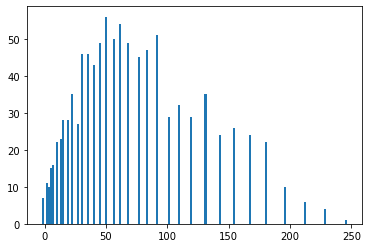

In [78]:
plt.hist(NPVs, bins=150)  ## I manualy set the "bins" parameter.
plt.show()

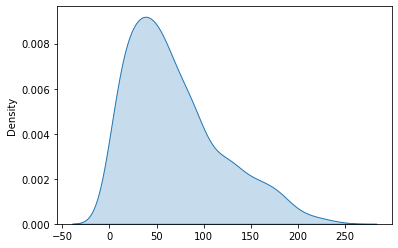

In [79]:
### For the KDE I used "seaborn" library.
sns.kdeplot(NPVs, shade=True);

<h3 style="line-height:200%;color:#0099cc">
Part 2
</h3>

Following function("status_modified(args)") is **almost** as same as the "status" function **except** for **fixed L_e**(here L_e is fixed and equal to 70) and **variable return**. You can see the modification for variable return in fourth inner function(blance(args)) which I iterate through an array of given returns.

In [80]:
def status_modified(L_e, age_s, s, a, w, g_p, g_w, r, n, L):
    """
    Set up a dataframe(main_data) containing four columns: salary, saving_flow, retirement_payments, balance
    it is "modified" because you can change "g_w" and "r" each year just by giving dictionary to "status_modified"
    L_e: Life expantancy 
    age_s: The age at which he\she begins working
    s: The percentage of his\her salary that he\she pays to the pension fund
    a: "a" is the percentage of the last yearly salary that is used to calculate the first pension payment
    w: Initial salary
    g_p: Pension payment annual growth rate
    g_w: Salary growth rate
    r: Pension fund annual return rate
    n: The number of years a person has contributed to their pension fund is shown by this parameter
    L: It's equal to (L_e - n - age_s)
    """
    main_data = pd.DataFrame()

    def salary():
        """
        Adds a column of annual salary to main_data
        """
        data = np.array([w *(1 + g_w/100) ** x for x in range(0,n)] + [0]*L)
        main_data["salary"] = data
        main_data.index = np.array([x for x in range(age_s+1,L_e+1)])
    
    salary()
    
    def saving_flow():
        """
        Adds a column of input cashflow(contribution) from the member(form the end of "age_s" to the end of "L_e") to the main_data
        """
        main_data["saving_flow"] = main_data["salary"] * s/100

    saving_flow()

    def retirement_payments():
        """
        Adds an array of retirement payments(from "age_s" to "L_e") to the main_data
        """
        last_salary = main_data.loc[age_s+n, "salary"]
        first_payment = last_salary * a / 100
        data2 = np.array([0]*n + [first_payment*(1 + g_p/100)**j for j in range(0,L)])
        main_data["retirement_payments"] = data2
        
    retirement_payments()

    ### midification
    def balance():
        """
        Adds an array of balance status(from "age_s" to "L_e") to the main_data
        """
        main_data['balance'] = main_data.saving_flow - main_data.retirement_payments
        for index,row in main_data.iterrows():
            if index == age_s+1:
                continue
            main_data.balance.loc[index] = main_data.balance.loc[index] + main_data.balance.loc[index-1] * (1 + r[index-age_s-2]/100)

    balance()

    return main_data




Here I randomly draw 49(n+L-1) samples from a ***Normal Distribution***(17, 3). The reason that I did not use percentile is that in all of my functions I consider this matter.

In [81]:
np.random.seed(0)
pension_return = (np.random.normal(17, 3, (40+10-1)))
pension_return


array([22.29215704, 18.20047163, 19.93621395, 23.7226796 , 22.60267397,
       14.06816636, 19.85026525, 16.54592838, 16.69034344, 18.23179551,
       17.43213071, 21.36282052, 19.28311318, 17.36502505, 18.3315897 ,
       18.00102298, 21.48223722, 16.38452521, 17.9392031 , 14.43771278,
        9.34103055, 18.96085579, 19.5933086 , 14.77350494, 23.80926387,
       12.63690298, 17.13727555, 16.43844845, 21.59833764, 21.40807631,
       17.46484228, 18.13448756, 14.33664276, 11.0576106 , 15.95626355,
       17.46904691, 20.69087204, 20.60713955, 15.83801955, 16.09309175,
       13.8543411 , 12.73994619, 11.88118943, 22.85232619, 15.47104345,
       15.6857771 , 13.24161392, 19.33247107, 12.15830646])

"stat2" dataframe contains inforamtion needed for solving part two.

In [82]:
stat2 = status_modified(L_e = 70, age_s = 20, s = 30, a = 80, w = 1, g_p = 20, g_w = 20, r = pension_return, n = 40, L = 10)
stat2

,salary,saving_flow,retirement_payments,balance
21,1.000000,0.300000,0.000000,0.300000
22,1.200000,0.360000,0.000000,0.726876
23,1.440000,0.432000,0.000000,1.291171
24,1.728000,0.518400,0.000000,2.066982
25,2.073600,0.622080,0.000000,3.179406
26,2.488320,0.746496,0.000000,4.644532
27,2.985984,0.895795,0.000000,6.193728
28,3.583181,1.074954,0.000000,8.498154
29,4.299817,1.289945,0.000000,11.194197
30,5.159780,1.547934,0.000000,14.610481


<h4 style="line-height:200%;color:#0099cc">
Plotting
</h4>

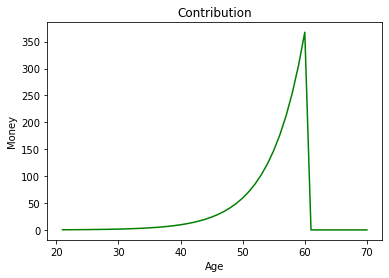

In [83]:
fig1, ax1 = plt.subplots()

ax1.plot(stat2.saving_flow, color='green')
ax1.set_title("Contribution")
ax1.set_ylabel('Money')
ax1.set_xlabel('Age');

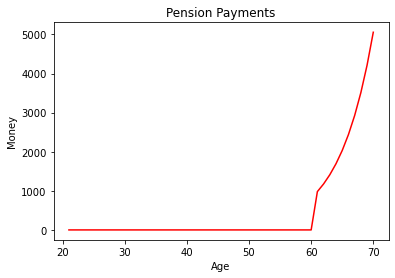

In [84]:
fig2, ax2 = plt.subplots()

ax2.plot(stat2.retirement_payments, color='red')
ax2.set_title("Pension Payments")
ax2.set_ylabel('Money')
ax2.set_xlabel('Age');

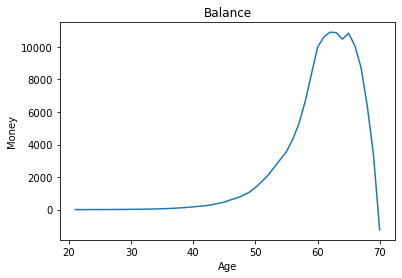

In [85]:
fig3, ax3 = plt.subplots()

ax3.plot(stat2.balance)
ax3.set_title("Balance")
ax3.set_ylabel('Money')
ax3.set_xlabel('Age');

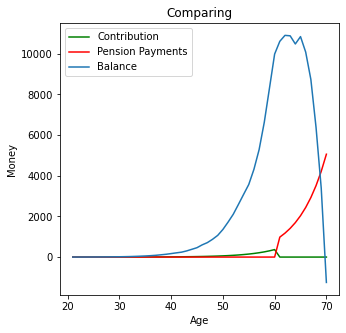

In [86]:
fig4, ax4 = plt.subplots(figsize=(5,5))

ax4.plot(stat2.saving_flow, color='green', label="Contribution")
ax4.plot(stat2.retirement_payments, color='red', label="Pension Payments")
ax4.plot(stat2.balance, label="Balance")
ax4.set_title("Comparing")
ax4.set_ylabel('Money')
ax4.set_xlabel('Age')
ax4.legend();


Now for the last part of part 2 I build a dataframe called "cashflow_comparison" which contain three columns: "fixed_return", "variable_return" and "difference".
First column contains cashflows for fixed return scenario, second one for variable return and "difference" column shows difference between two cash flows.
Cashflow of each year is calculated from the equation below:
$$Cashflow_1 = balance_1$$
$$Cashflow_i = balance_i - balance_{i-1}\hspace{0.5cm}\forall i>1$$
And "difference" column is calculated from equation below:
$$difference_i = Cashflow_{variable\hspace{0.1cm}return} - Cashflow_{fixed\hspace{0.1cm}return}$$

In [87]:
cashflow_comparison = pd.DataFrame()
fixed_return = status(age_s = 20, s = 30, a = 80, w = 1, g_p = 20, g_w = 20, r = 17, n = 40, L = 10)
cashflow_comparison["fixed_return"] = fixed_return.balance.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
cashflow_comparison["fixed_return"][21] = fixed_return.balance[21]
cashflow_comparison["variable_return"] = stat2.balance.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
cashflow_comparison["variable_return"][21] = stat2.balance[21]
cashflow_comparison["difference"] = cashflow_comparison["variable_return"] - cashflow_comparison["fixed_return"]
cashflow_comparison

,fixed_return,variable_return,difference
21,0.300000,0.300000,0.000000
22,0.411000,0.426876,0.015876
23,0.552870,0.564295,0.011425
24,0.733258,0.775811,0.042553
25,0.961592,1.112424,0.150832
26,1.249478,1.465127,0.215648
27,1.611189,1.549196,-0.061993
28,2.064250,2.304426,0.240176
29,2.630163,2.696044,0.065880
30,3.335280,3.416284,0.081004


<h4 style="line-height:200%;color:#0099cc">
Plotting
</h4>

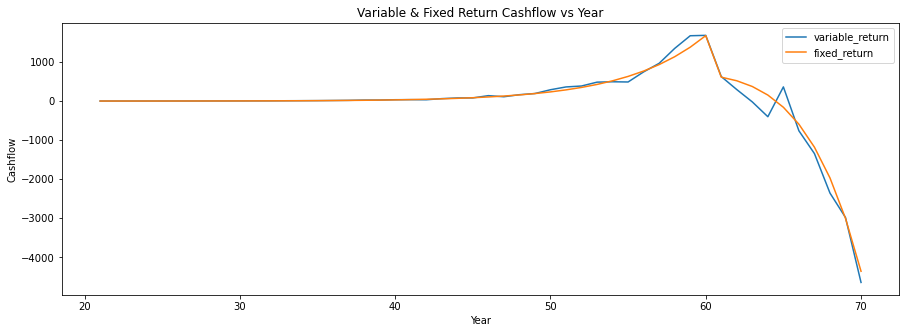

In [88]:
cashflow_comparison.loc[:, ["variable_return", "fixed_return"]].plot(figsize=(15,5), title="Variable & Fixed Return Cashflow vs Year", xlabel="Year", ylabel="Cashflow");

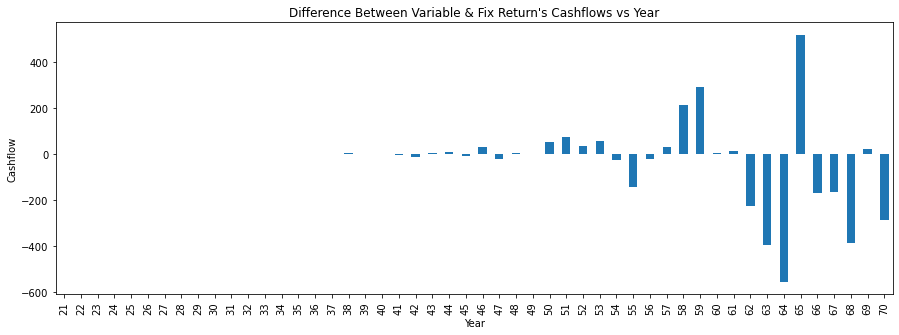

In [89]:
cashflow_comparison["difference"].plot.bar(figsize=(15,5), title="Difference Between Variable & Fix Return's Cashflows vs Year", xlabel="Year", ylabel="Cashflow");

<h5 style="line-height:200%;color:#0099cc">
Comparing Two Approach
</h5>
In the real world, the variable return model makes more sense since variable returns are more rational than fixed returns over a 50-year period. But there is a little drawback in this model. It is difficult to accept a substantial change in pension fund return within a year. For example there is 9% and then 18% return in two consecutive years. The reason for this drawback is that we used a fixed mean in the normal distribution. As a solution, the return of last year could be used as the mean for normal distribution.

<h3 style="line-height:200%;color:#0099cc">
Part 3
</h3>
As you can see, the function below matches exactly the one from miniproject 1, which returns a dataframe containing "salary", "saving_flow", "retirement_payments" and "balance".

In [90]:
def status_miniproject1(L_e, age_s, s, a, w, g_p, g_w, r, n):
    """
    Set up a dataframe(main_data) containing four columns: salary, saving_flow, retirement_payments, balance
    L_e: Life expantancy 
    age_s: The age at which he\she begins working
    s: The percentage of his\her salary that he\she pays to the pension fund
    a: "a" is the percentage of the last yearly salary that is used to calculate the first pension payment
    w: Initial salary
    g_p: Pension payment annual growth rate
    g_w: Salary growth rate
    r: Pension fund annual return rate
    n: The number of years a person has contributed to their pension fund is shown by this parameter
    L: It's equal to (L_e - n - age_s)
    """
    main_data = pd.DataFrame()
    
    def salary():
        """
        Adds a column of annual salary to main_data
        """
        data = np.array([w *(1 + g_w/100) ** x for x in range(0,n)] + [0]*(L_e - n - age_s))
        main_data["salary"] = data
        main_data.index = np.array([x for x in range(age_s+1,L_e+1)])
    
    salary()

    def saving_flow():
        """
        Adds a column of input cashflow(contribution) from the member(form the end of "age_s" to the end of "L_e") to the main_data
        """
        main_data["saving_flow"] = main_data["salary"] * s/100
    
    saving_flow()

    def retirement_payments():
        """
        Adds an array of retirement payments(from "age_s" to "L_e") to the main_data
        """
        last_salary = main_data.loc[age_s+n, "salary"]
        first_payment = last_salary * a / 100
        data2 = np.array([0]*n + [first_payment*(1 + g_p/100)**j for j in range(0,L_e - n - age_s)])
        main_data["retirement_payments"] = data2

    retirement_payments()


    def balance():
        """
        Adds an array of balance status(from "age_s" to "L_e") to the main_data
        """
        main_data['balance'] = main_data.saving_flow - main_data.retirement_payments
        for index,row in main_data.iterrows():
            if index == age_s+1:
                continue
            main_data.balance.loc[index] = main_data.balance.loc[index] + main_data.balance.loc[index-1] * (1 + r/100)
    
    balance()

    return main_data



<h5 style="line-height:200%;color:#0099cc">
Sensitivity Analysis & Optimization<br>
Part 3.1
</h5>

In [91]:
returns_on_investment = [2*x for x in range(-5,16)]  ### [-10, -8, ..., 30]
wage_growth_rates = [10, 15, 20, 25]

from scipy import optimize
age_s =20
r_d = 14
def NPV_pension_2(n, gw, r):
    """
    Returns NPV of the pension fund according to rate of return of "n", wage growth rate("gw" or "g_w") and return of pension fund("r").
    Due to optimize.brentq only accepting functions with continuous inputs, I used int(n) instead of n(status_miniproject1 don't accept float for number of years of work(n))
    """
    n = int(n)
    L = 10
    temp_dataframe = status_miniproject1(70, 20, 30, 80, 1, 20, gw, r, n)
    temp_balance = temp_dataframe.balance.diff().fillna(temp_dataframe['balance'].loc[age_s+1])  ## difference between each row, index={21,22,...,70}
    temp_balance.index -= age_s  ## index={1,2,...,50}
    DCF = temp_balance.divide( (1 + r_d/100) ** temp_balance.index) ### dicounted blance each year 
    npv = DCF.sum()
    return npv

def root_finder(gw, r): 
    """
    Returns the "n" for given return rate("r") and wage growth rate("gw" or "g_w") if NPV is approximately zero
    "n" is rounded to the nearest integer
    """   
    root = optimize.brentq(NPV_pension_2, 1, 50, args=(gw, r))
    return round(root)


### beacause of using scipy.optimization it will take a while(2min)
r_n_gw = pd.DataFrame()
r_n_gw["g_w = 10%"] = [root_finder(10, x) for x in returns_on_investment]
r_n_gw["g_w = 15%"] = [root_finder(15, x) for x in returns_on_investment]
r_n_gw["g_w = 20%"] = [root_finder(20, x) for x in returns_on_investment]
r_n_gw["g_w = 25%"] = [root_finder(25, x) for x in returns_on_investment]

r_n_gw

,g_w = 10%,g_w = 15%,g_w = 20%,g_w = 25%
0,35,42,46,47
1,35,41,45,47
2,35,41,45,47
3,34,41,45,47
4,34,40,44,46
5,33,40,44,46
6,33,39,43,46
7,32,38,43,45
8,32,37,42,45
9,31,36,41,44


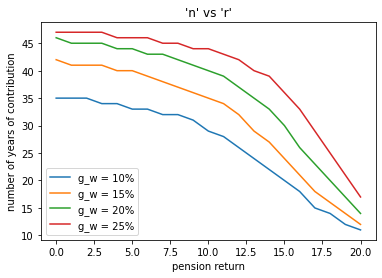

In [92]:
r_n_gw.plot(title="'n' vs 'r'", xlabel="pension return", ylabel="number of years of contribution");

<h5 style="line-height:200%;color:#0099cc">
Part 3.2
</h5>

In [93]:
returns_on_investment = [2*x for x in range(-5,16)]
pension_growth_rates = [15, 20, 25, 30]


def NPV_pension_3(n, gp, r):
    """
    Returns NPV of the pension fund according to rate of return of "n", pension growth rate("gp" or "g_p") and return of pension fund("r").
    Due to optimize.brentq only accepting functions with continuous inputs, I used int(n) instead of n(status don't accept float for number of years of work(n))
    """
    n = int(n)
    L = 10
    temp_dataframe = status_miniproject1(70, 20, 30, 80, 1, gp, 20, r, n)
    temp_balance = temp_dataframe.balance.diff().fillna(temp_dataframe['balance'].loc[age_s+1])  ## difference between each row, index={21,22,...,70}
    temp_balance.index -= age_s  ## index={1,2,...,50}
    DCF = temp_balance.divide( (1 + r_d/100) ** temp_balance.index) ### dicounted blance each year 
    npv = DCF.sum()
    return npv

def root_finder(gp, r): 
    """
    Returns the "n" for given return rate("r") and pension growth rate("gp" or "g_p") if NPV is approximately zero
    "n" is rounded to the nearest integer
    """   
    root = optimize.brentq(NPV_pension_3, 1, 50, args=(gp, r))
    return round(root)

### beacause of using scipy.optimization it will take a while(2min)
r_n_gp = pd.DataFrame()
r_n_gp["g_p = 15%"] = [root_finder(15, x) for x in returns_on_investment]
r_n_gp["g_p = 20%"] = [root_finder(20, x) for x in returns_on_investment]
r_n_gp["g_p = 25%"] = [root_finder(25, x) for x in returns_on_investment]
r_n_gp["g_p = 30%"] = [root_finder(30, x) for x in returns_on_investment]

r_n_gp

,g_p = 15%,g_p = 20%,g_p = 25%,g_p = 30%
0,45,46,46,46
1,45,45,46,46
2,44,45,45,46
3,44,45,45,46
4,44,44,45,45
5,43,44,44,45
6,43,43,44,45
7,42,43,44,44
8,41,42,43,44
9,40,41,42,43


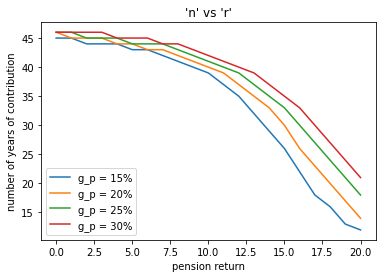

In [94]:
r_n_gp.plot(title="'n' vs 'r'", xlabel="pension return", ylabel="number of years of contribution");

<h5 style="line-height:200%;color:#0099cc">
Part 3.3
</h5>

In [95]:
returns_on_investment = [2*x for x in range(-5,16)]
pension_growth_rates = [10, 20, 30, 40, 50, 60]


def NPV_pension_4(n, s, r):
    """
    Returns NPV of the pension fund according to rate of return of "n", "s" and return of pension fund("r").
    Due to optimize.brentq only accepting functions with continuous inputs, I used int(n) instead of n(status don't accept float for number of years of work(n))
    """
    n = int(n)
    L = 10
    temp_dataframe = status_miniproject1(70, 20, s, 80, 1, 20, 20, r, n)
    temp_balance = temp_dataframe.balance.diff().fillna(temp_dataframe['balance'].loc[age_s+1])  ## difference between each row, index={21,22,...,70}
    temp_balance.index -= age_s  ## index={1,2,...,50}
    DCF = temp_balance.divide( (1 + r_d/100) ** temp_balance.index) ### dicounted blance each year 
    npv = DCF.sum()
    return npv

def root_finder(s, r): 
    """
    Returns the "n" for given return rate("r") and s if NPV is approximately zero
    "n" is rounded to the nearest integer
    """   
    root = optimize.brentq(NPV_pension_4, 1, 50, args=(s, r))
    return round(root)

### beacause of using scipy.optimization it will take a while(3min)
r_n_s = pd.DataFrame()
r_n_s["s = 10%"] = [root_finder(10, x) for x in returns_on_investment]
r_n_s["s = 20%"] = [root_finder(20, x) for x in returns_on_investment]
r_n_s["s = 30%"] = [root_finder(30, x) for x in returns_on_investment]
r_n_s["s = 40%"] = [root_finder(40, x) for x in returns_on_investment]
r_n_s["s = 50%"] = [root_finder(50, x) for x in returns_on_investment]
r_n_s["s = 60%"] = [root_finder(60, x) for x in returns_on_investment]


r_n_s

,s = 10%,s = 20%,s = 30%,s = 40%,s = 50%,s = 60%
0,49,47,46,44,43,41
1,49,47,45,44,42,41
2,49,47,45,43,42,41
3,48,46,45,43,42,40
4,48,46,44,43,41,40
5,48,46,44,42,41,39
6,48,45,43,42,40,39
7,47,45,43,41,39,38
8,47,44,42,40,39,37
9,47,44,41,39,37,36


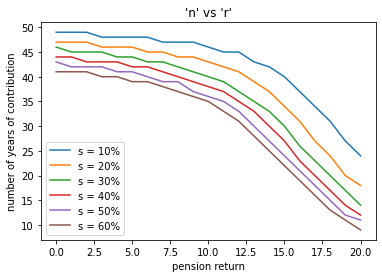

In [96]:
r_n_s.plot(title="'n' vs 'r'", xlabel="pension return", ylabel="number of years of contribution");